In [97]:
import pandas as pd
import time
import math
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
import statistics

In [2]:
def read_in_tables(n=78):
    df_list = {}
    for i in range(1, n):

        table1_name = 'test_df' + str(i)
        table2_name = 'train_df' + str(i)

        df = pd.read_csv(f'../datasets/training/SARIMA/by_area/ml_{i}.csv', parse_dates=['date'])

        globals()[table1_name] = df[(df.date <= pd.to_datetime('2019-12-31')) & (df.date >= pd.to_datetime('2019-01-01'))]
        globals()[table2_name] = df[(df.date < pd.to_datetime('2019-01-01')) & (df.date > pd.to_datetime('2016-01-01'))]

        globals()[table1_name].fillna(0, inplace=True)
        globals()[table2_name].fillna(0, inplace=True)

        globals()[table1_name].set_index('date', inplace=True)
        globals()[table2_name].set_index('date', inplace=True)

        df_list[table1_name] = globals()[table1_name]
        df_list[table2_name] = globals()[table2_name]

    return df_list

In [3]:
tables = read_in_tables()
len(tables)

/var/folders/5d/fdmfhfr55d5f2r62ltcl50vh0000gn/T/ipykernel_73639/1195836211.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[table1_name].fillna(0, inplace=True)
/var/folders/5d/fdmfhfr55d5f2r62ltcl50vh0000gn/T/ipykernel_73639/1195836211.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[table2_name].fillna(0, inplace=True)
/var/folders/5d/fdmfhfr55d5f2r62ltcl50vh0000gn/T/ipykernel_73639/1195836211.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

154

In [4]:
train_df1

,non-violent,violent,train_rides,bike_rides,lighting,vacant_buildings
date,,,,,,
2016-01-01 01:00:00,1.0,1.0,8811.0,0.0,43.0,76.0
2016-01-01 02:00:00,0.0,0.0,8811.0,1.0,43.0,76.0
2016-01-01 03:00:00,0.0,2.0,8811.0,0.0,43.0,76.0
2016-01-01 04:00:00,0.0,0.0,8811.0,0.0,43.0,76.0
2016-01-01 05:00:00,0.0,0.0,8811.0,0.0,43.0,76.0
...,...,...,...,...,...,...
2018-12-31 19:00:00,1.0,0.0,10661.0,2.0,0.0,92.0
2018-12-31 20:00:00,0.0,0.0,10661.0,0.0,0.0,92.0
2018-12-31 21:00:00,0.0,0.0,10661.0,2.0,0.0,92.0


In [5]:
def create_aggregated_columns(df, target_cols):
    """
    Create new columns for each numeric column with aggregated values of the previous 6, 12, and 24 hours.
    Fill nulls with zeros after the initial nulls when the rolling window size hasn't been met yet.

    Parameters:
    - df: DataFrame with datetime index and numeric columns to be aggregated

    Returns:
    - DataFrame with new aggregated columns
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    for column in target_cols:
        # Create new columns with aggregated values
        df_copy[f'{column}_6h_agg'] = df_copy[column].rolling(window=6, min_periods=1).sum().fillna(0)
        df_copy[f'{column}_12h_agg'] = df_copy[column].rolling(window=12, min_periods=1).sum().fillna(0)
        df_copy[f'{column}_24h_agg'] = df_copy[column].rolling(window=24, min_periods=1).sum().fillna(0)
    
    return df_copy

In [6]:
train_df1

,non-violent,violent,train_rides,bike_rides,lighting,vacant_buildings
date,,,,,,
2016-01-01 01:00:00,1.0,1.0,8811.0,0.0,43.0,76.0
2016-01-01 02:00:00,0.0,0.0,8811.0,1.0,43.0,76.0
2016-01-01 03:00:00,0.0,2.0,8811.0,0.0,43.0,76.0
2016-01-01 04:00:00,0.0,0.0,8811.0,0.0,43.0,76.0
2016-01-01 05:00:00,0.0,0.0,8811.0,0.0,43.0,76.0
...,...,...,...,...,...,...
2018-12-31 19:00:00,1.0,0.0,10661.0,2.0,0.0,92.0
2018-12-31 20:00:00,0.0,0.0,10661.0,0.0,0.0,92.0
2018-12-31 21:00:00,0.0,0.0,10661.0,2.0,0.0,92.0


In [7]:
temp_train_df = create_aggregated_columns(train_df1, ['non-violent', 'violent', 'bike_rides'])
temp_test_df = create_aggregated_columns(test_df1, ['non-violent', 'violent', 'bike_rides'])
temp_train_df.head(10)

,non-violent,violent,train_rides,bike_rides,lighting,vacant_buildings,non-violent_6h_agg,non-violent_12h_agg,non-violent_24h_agg,violent_6h_agg,violent_12h_agg,violent_24h_agg,bike_rides_6h_agg,bike_rides_12h_agg,bike_rides_24h_agg
date,,,,,,,,,,,,,,,
2016-01-01 01:00:00,1.0,1.0,8811.0,0.0,43.0,76.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.0,0.0,8811.0,1.0,43.0,76.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-01 03:00:00,0.0,2.0,8811.0,0.0,43.0,76.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0
2016-01-01 04:00:00,0.0,0.0,8811.0,0.0,43.0,76.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0
2016-01-01 05:00:00,0.0,0.0,8811.0,0.0,43.0,76.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0
2016-01-01 06:00:00,0.0,0.0,8811.0,2.0,43.0,76.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0
2016-01-01 07:00:00,0.0,0.0,8811.0,0.0,43.0,76.0,0.0,1.0,1.0,2.0,3.0,3.0,3.0,3.0,3.0
2016-01-01 08:00:00,0.0,0.0,8811.0,0.0,43.0,76.0,0.0,1.0,1.0,2.0,3.0,3.0,2.0,3.0,3.0
2016-01-01 09:00:00,0.0,0.0,8811.0,2.0,43.0,76.0,0.0,1.0,1.0,0.0,3.0,3.0,4.0,5.0,5.0


In [8]:
temp_test_df.head(10)

,non-violent,violent,train_rides,bike_rides,lighting,vacant_buildings,non-violent_6h_agg,non-violent_12h_agg,non-violent_24h_agg,violent_6h_agg,violent_12h_agg,violent_24h_agg,bike_rides_6h_agg,bike_rides_12h_agg,bike_rides_24h_agg
date,,,,,,,,,,,,,,,
2019-01-01 00:00:00,1.0,1.0,6898.0,0.0,0.0,92.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2019-01-01 01:00:00,0.0,1.0,6898.0,0.0,0.0,92.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0
2019-01-01 02:00:00,1.0,0.0,6898.0,0.0,0.0,92.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0
2019-01-01 03:00:00,0.0,0.0,6898.0,2.0,0.0,92.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2019-01-01 04:00:00,0.0,1.0,6898.0,0.0,0.0,92.0,2.0,2.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0
2019-01-01 05:00:00,0.0,0.0,6898.0,0.0,0.0,92.0,2.0,2.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0
2019-01-01 06:00:00,1.0,0.0,6898.0,0.0,0.0,92.0,2.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0
2019-01-01 07:00:00,0.0,0.0,6898.0,0.0,0.0,92.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,2.0,2.0
2019-01-01 08:00:00,1.0,0.0,6898.0,1.0,0.0,92.0,2.0,4.0,4.0,1.0,3.0,3.0,3.0,3.0,3.0


In [109]:
class LinearRegression:
    # Class-level attributes for model coefficients and parameters
    m = []  # Model coefficients for features
    b = 0   # Model intercept
    initial_learning_rate = 0.01  # Initial learning rate (how fast the model moves the coefficients)
    learning_rate = initial_learning_rate
    learning_rate_decay = 0.99    # Learning rate decay factor (over time the learning rate will shrink at this rate)
    epochs = 100  # Number of training epochs (maximum number of iterations to run the model through before finding the values corresponding with the minimum error)
    data = None 
    test_dataset = None
    train_dataset = None
    length = 0
    feature_columns = [] # Input columns
    target_column = "" # Output column
    losses = {}  # Store loss values during training

    def __init__(self, dataset, feature_columns, target_column, initial_learning_rate=0.01, epochs=100, learning_rate_decay=0.99):
        """
        Initialize the LinearRegression model.

        Parameters:
        - dataset: pandas DataFrame, the dataset to train and test the model.
        - feature_columns: list of str, column names representing features.
        - target_column: str, the column name representing the target variable.
        - initial_learning_rate: float, the initial learning rate for gradient descent.
        - epochs: int, the number of training epochs.
        - learning_rate_decay: float, the factor by which learning rate decays at each epoch.
        """
        # Define class properties
        self.data = dataset
        self.feature_columns = feature_columns
        self.target_column = target_column
        self.initial_learning_rate = initial_learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.epochs = epochs
        self.length = len(dataset)

        # Make a unique coefficient value for each feature column
        for feature in feature_columns:
            self.m.append(0)

    def loss(self, df):
        """
        Calculate the mean squared error loss of the model on a dataset.

        Parameters:
        - df: pandas DataFrame, the dataset on which to calculate the loss.

        Returns:
        - str: A string representing the total error normalized by the mean target value.
        """
        # Initialize our variables
        total_error = 0
        total_y = 0

        # Iterating through every row of the passed dataframe
        for i in range(len(df)):
            
            # Define our x values as a vector of each feature column at the current row
            x = [df.iloc[i][col] for col in self.feature_columns]

            # Grab our expected y value to compare our predicted y value against
            y = df.iloc[i][self.target_column]

            # Sum the products of each coefficient and corresponding x value 
            total_m = sum(self.m[j] * x[j] for j in range(len(self.feature_columns)))
            total_y += (total_m + self.b)

            # Calculate squared difference
            total_error += (y - (total_m + self.b)) ** 2

        # Average values over each row
        total_error /= float(len(df))
        total_y /= float(len(df))

        return total_error, f'Total Error for the Model: {total_error} | Relative Error for the Model: {total_error / abs(total_y)}'

    def gradient_descent(self, m_now, b_now):
        """
        Perform one step of gradient descent to update model coefficients.

        Parameters:
        - m_now: list of float, current model coefficients for features.
        - b_now: float, current model intercept.

        Returns:
        - list of float: Updated model coefficients for features.
        - float: Updated model intercept.
        """
        # Initalize a gradient variable for each feature column
        m_gradients = [0] * (len(self.feature_columns))
        b_gradient = 0

        # Iterate through every row
        for i in range(self.length):

            # Define our x values as a vector of each feature column at the current row
            x = [self.train_dataset.iloc[i][col] for col in self.feature_columns]

            # Grab our expected y value to compare our predicted y value against
            y = self.train_dataset.iloc[i][self.target_column]

            # Sum the products of each coefficient and corresponding x value 
            total_m = sum(m_now[j] * x[j] for j in range(len(self.feature_columns)))

            # Take the derivative with respect to b
            b_gradient += -(2 / self.length) * (y - (total_m + b_now))

            # Take the derivative with respect to m
            for j in range(len(self.feature_columns)):
                m_gradients[j] += -(2 / self.length) * x[j] * (y - (total_m + b_now))

        # Updated the model's coefficients based on the gradient values
        updated_m = [m_now[j] - m_gradients[j] * self.learning_rate for j in range(len(self.feature_columns))]
        updated_b = b_now - b_gradient * self.learning_rate

        return updated_m, updated_b

    def train(self, ratio=0.1, max_epochs=None, min_loss_delta=0.01, patience=10):
        """
            Train the Linear Regression model using gradient descent.

            This method iteratively updates the model's coefficients and intercept using gradient descent. It monitors the training process for convergence and stops training based on specified conditions, such as the maximum number of epochs, loss improvement, or patience.

            Parameters:
            - ratio (float): The fraction of the maximum epochs used for checkpointing.
            - max_epochs (int): The maximum number of training epochs.
            - min_loss_delta (float): The minimum change in loss to continue training.
            - patience (int): The number of epochs to tolerate a lack of improvement.

            Returns:
            - None

            Raises:
            - ValueError: If max_epochs is not provided or is less than or equal to 0.

            This method also sets the model's parameters to the values associated with the minimum stored loss during training.

            """
        
        if max_epochs is None:
            raise ValueError("You must provide a value for max_epochs.")
        if max_epochs <= 0:
            raise ValueError("max_epochs must be greater than 0.")
        
        # Initialize variables
        checkpoint = round(max_epochs * ratio)
        learning_rate = self.initial_learning_rate
        prev_loss = float('inf')
        min_loss = float('inf')
        patience_counter = 0
        loss_history = []
        
        for i in range(max_epochs):
            # Save coefficients in case we want to revert back after calculating error
            temp_m = self.m
            temp_b = self.b

            # Determine gradient descent
            self.m, self.b = self.gradient_descent(self.m, self.b)

            # Determine the loss of the updated model 
            loss, string = self.loss(self.train_dataset[:i + 1])
            self.losses[loss] = self.m, self.b

            # If the error loss is increasing by a statistically determined amount add one to the patience counter, which will break the loop when it consecutively reaches the threshold
            if (prev_loss != float('inf')) and ((loss - prev_loss >= prev_loss * 0.5) or (loss >= min_loss)) and (loss < statistics.stdev(self.train_dataset[self.target_column])):
                patience_counter += 1

            # If the error is moving down, reset the patience counter and update the minimum loss variable
            elif loss < min_loss:
                min_loss = loss
                patience_counter = 0

            # Otherwise the error loss is increasing slightly
            else:
                patience_counter = 0

            # Add the loss to our lost history storage
            loss_history.append(loss)

            # Every predetermined checkpoint we print updates
            if (i % checkpoint == 0) and (i != 0):
                print(f'{time.strftime("%Y-%m-%d %H:%M:%S")} - Epoch {i} - {string}')
                print(self.m, self.b)

            # If the patience counter has surpassed the patience threshold, exit the loop
            if patience_counter >= patience:
                print(f"Training stopped due to lack of improvement for {patience} epochs. Current Error - {loss}")
                break

            # Updated loss and learning rate variables
            prev_loss = loss
            learning_rate *= self.learning_rate_decay
            self.learning_rate = learning_rate

            # Calculate moving average of the loss history
            if i >= patience:
                recent_losses = loss_history[-patience:]
                moving_average = np.mean(recent_losses)
                if moving_average < min_loss_delta:
                    print(f"Training stopped due to a small moving average loss change.")
                    break

        # Set the parameters to the ones with the minimum stored loss
        min_loss = min(self.losses.keys())
        self.m, self.b = self.losses[min_loss]
        print(f'Training Complete. Final Error: {min_loss}')

    def split_datasets(self, frac=0.2):
        """
        Split the dataset into training and testing subsets.

        Parameters:
        - frac: float, the fraction of data to be used for testing.

        Returns:
        - None
        """
        # Split the primary dataset into a test and training dataset based on the passed fraction
        test = self.data.sample(frac=frac)
        train = self.data.sample(frac=1-frac)
        self.train_dataset = train
        self.test_dataset = test

    def predict(self, data):
        """
        Make predictions using the trained model.

        Parameters:
        - data: pandas DataFrame, the dataset for which to make predictions.

        Returns:
        - list of float: Predicted values based on the model.
        """
        prediction = []

        # Iterate through every row
        for i in range(len(data)):

            # Create a vector of all x values at the current column
            x = [data.iloc[i][col] for col in data.columns]

            # Sum the product of all x values and their respective coefficients
            total_m = sum(self.m[j] * x[j] for j in range(len(data.columns)))

            # Calculate the predicted y-value and add it to the output list
            y = total_m + self.b
            prediction.append(y)

        return prediction

    def test_results(self):
        """
        Calculate and return the loss on the test dataset.

        Returns:
        - str: A string representing the total error normalized by the mean target value on the test dataset.
        """
        # Return the calculated error loss for the saved test-dataset
        return self.loss(self.test_dataset)

    def set_train_dataset(self, dataset):
        """
        Set the training dataset.

        Parameters:
        - dataset: pandas DataFrame, the training dataset.
        """
        self.train_dataset = dataset

    def set_test_dataset(self, dataset):
        """
        Set the testing dataset.

        Parameters:
        - dataset: pandas DataFrame, the testing dataset.
        """
        self.test_dataset = dataset

    def reset_losses(self):
        """
        Reset the list of loss values.
        """
        self.losses = {}

    def list_to_models(self, data, output=None, initial_learning_rate=0.0001, learning_rate_decay=0.999, epochs=500, max_epochs=None, patience=10):
        """
        Generate a dictionary of models with varying feature columns and training each model.

        This method trains multiple Linear Regression models with different sets of feature columns. 
        It iterates through the provided list of feature columns and for each set of features, 
        it trains a Linear Regression model.

        Parameters:
        - data: pandas DataFrame, the dataset to use for training all models.
        - output (dict): A dictionary to store the results of each model. If not provided, 
        a new dictionary will be created.
        - initial_learning_rate (float): The initial learning rate for gradient descent.
        - learning_rate_decay (float): The factor by which learning rate decays at each epoch.
        - epochs (int): The number of training epochs for each model.
        - max_epochs (int): Maximum number of epochs to run for each model.

        Returns:
        - dict: A dictionary containing the results and models for each trained model.
        """

        if output is None:
            output = {}

        # Iterate through the list of feature columns, running a model with an additional feature column each time
        for i in range(1, len(self.feature_columns) + 1):
            temp_results = {}
            model_name = 'temp_model_' + str(i)

            # Create a model instance with a subset of feature columns
            model_instance = LinearRegression(data, self.feature_columns[:i], 'non-violent', initial_learning_rate, 
            epochs=(epochs + math.floor(i / 2) * 2 * epochs), learning_rate_decay=learning_rate_decay)

            # Set training data as the model's training dataset
            model_instance.set_train_dataset(data)

            # Train the model with a maximum number of epochs and patience
            model_instance.train(max_epochs=epochs, patience=patience)

            # Store the results in a dictionary
            temp_results['results'] = model_instance.model()
            temp_results['model'] = model_instance
            output[model_name] = temp_results

            # Print progress
            print(f"Trained {model_name} with {i} feature columns.")
            print(f"Model: {model_instance.model()}")

        return output
        
    def lasso_regularization(self, alpha):
        """
        Apply L1 (Lasso) regularization to the model.

        Parameters:
        - alpha: float, regularization strength.
        """
        for i in range(len(self.m)):
            if self.m[i] > 0:
                self.m[i] -= alpha
            elif self.m[i] < 0:
                self.m[i] += alpha
        print("L1 (Lasso) regularization applied.")

    def ridge_regularization(self, alpha):
        """
        Apply L2 (Ridge) regularization to the model.

        Parameters:
        - alpha: float, regularization strength.
        """
        for i in range(len(self.m)):
            self.m[i] -= 2 * alpha * self.m[i]
        print("L2 (Ridge) regularization applied.")

    def cross_validation(self, k=5):
        """
        Perform k-fold cross-validation to assess model performance.

        Parameters:
        - k: int, number of folds for cross-validation.

        Returns:
        - dict: Dictionary containing evaluation metrics for each fold.
        """
        # Split data into k folds
        fold_size = len(self.data) // k
        metrics = {'MAE': [], 'RMSE': [], 'R-squared': []}

        for i in range(k):
            # Create train and test datasets for the current fold
            start = i * fold_size
            end = start + fold_size
            test_fold = self.data[start:end]
            train_fold = pd.concat([self.data[:start], self.data[end:]])

            # Train the model on the training fold
            self.set_train_dataset(train_fold)
            self.train()

            # Make predictions on the test fold
            predictions = self.predict(test_fold)

            # Calculate evaluation metrics for this fold
            mae = self.mean_absolute_error(predictions)
            rmse = self.root_mean_squared_error(predictions)
            r_squared = self.r_squared(predictions)

            metrics['MAE'].append(mae)
            metrics['RMSE'].append(rmse)
            metrics['R-squared'].append(r_squared)
            print(f"Cross-validation fold {i+1} completed.")
        
        print("Cross-validation completed.")
        return metrics

    def standardize_features(self):
        """
        Standardize feature columns using StandardScaler.
        """
        scaler = StandardScaler()
        self.data[self.feature_columns] = scaler.fit_transform(self.data[self.feature_columns])
        print("Features standardized using StandardScaler.")

    def min_max_scaling(self):
        """
        Apply Min-Max scaling to feature columns.
        """
        min_max_scaler = MinMaxScaler()
        self.data[self.feature_columns] = min_max_scaler.fit_transform(self.data[self.feature_columns])
        print("Min-Max scaling applied to feature columns.")

    def mean_absolute_error(self, predictions):
        """
        Calculate Mean Absolute Error (MAE) for model predictions.

        Parameters:
        - predictions: list of float, predicted values.

        Returns:
        - float: Mean Absolute Error.
        """
        return np.mean(np.abs(predictions - self.test_dataset[self.target_column]))

    def root_mean_squared_error(self, predictions):
        """
        Calculate Root Mean Squared Error (RMSE) for model predictions.

        Parameters:
        - predictions: list of float, predicted values.

        Returns:
        - float: Root Mean Squared Error.
        """
        return np.sqrt(np.mean((predictions - self.test_dataset[self.target_column]) ** 2))

    def r_squared(self, predictions):
        """
        Calculate R-squared (coefficient of determination) for model predictions.

        Parameters:
        - predictions: list of float, predicted values.

        Returns:
        - float: R-squared.
        """
        ssr = np.sum((predictions - self.test_dataset[self.target_column]) ** 2)
        sst = np.sum((self.test_dataset[self.target_column] - np.mean(self.test_dataset[self.target_column])) ** 2)
        return 1 - (ssr / sst)

    def hyperparameter_tuning(self, parameter_grid, scoring='neg_mean_squared_error', cv=5):
        """
        Perform hyperparameter tuning using grid search or random search.

        Parameters:
        - parameter_grid: dict, a dictionary of hyperparameter values to search.
        - scoring: str, the scoring metric to optimize.
        - cv: int, the number of cross-validation folds.

        Returns:
        - dict: Dictionary containing the best hyperparameters and their corresponding performance.
        """
        # Create a model instance
        model = LinearRegression(self.data, self.feature_columns, self.target_column)

        # Perform hyperparameter tuning
        grid_search = GridSearchCV(model, parameter_grid, scoring=scoring, cv=cv)
        grid_search.fit(self.data[self.feature_columns], self.data[self.target_column])

        # Get the best hyperparameters and their corresponding performance
        best_hyperparameters = grid_search.best_params_
        best_performance = grid_search.best_score_

        return {'best_hyperparameters': best_hyperparameters, 'best_performance': best_performance}

    def model(self):
        """
        Generate and return the equation of the trained linear regression model.

        Returns:
        - str: The equation of the linear regression model.
        """
        model_parts = [f'({self.m[i]} * {col})' for i, col in enumerate(self.feature_columns)]
        model_str = ' + '.join(model_parts)

        if self.b >= 0:
            model = f'y = {model_str} + {self.b}'
        else:
            temp_b = abs(self.b)
            model = f'y = {model_str} - {temp_b}'

        return model

In [10]:
def normalize_dataframe(df):
    """
    Normalize all columns in a pandas DataFrame.
    
    Parameters:
    - df: The input pandas DataFrame.
    
    Returns:
    - A new DataFrame with normalized values.
    """
    # Calculate the mean and standard deviation for each column
    means = df.mean()
    stds = df.std()
    
    # Normalize each column
    normalized_df = (df - means) / stds
    
    return normalized_df

In [11]:
temp_test_df = normalize_dataframe(temp_test_df)
temp_test_df

,non-violent,violent,train_rides,bike_rides,lighting,vacant_buildings,non-violent_6h_agg,non-violent_12h_agg,non-violent_24h_agg,violent_6h_agg,violent_12h_agg,violent_24h_agg,bike_rides_6h_agg,bike_rides_12h_agg,bike_rides_24h_agg
date,,,,,,,,,,,,,,,
2019-01-01 00:00:00,1.205215,2.240158,-2.232300,-0.851841,NaN,NaN,-0.533437,-1.144577,-1.872548,0.145262,-0.517928,-1.265275,-1.146133,-1.455295,-1.835109
2019-01-01 01:00:00,-0.533878,2.240158,-2.232300,-0.851841,NaN,NaN,-0.533437,-1.144577,-1.872548,1.168476,0.205962,-0.744589,-1.146133,-1.455295,-1.835109
2019-01-01 02:00:00,1.205215,-0.373872,-2.232300,-0.851841,NaN,NaN,0.101134,-0.717189,-1.577633,1.168476,0.205962,-0.744589,-1.146133,-1.455295,-1.835109
2019-01-01 03:00:00,-0.533878,-0.373872,-2.232300,-0.579792,NaN,NaN,0.101134,-0.717189,-1.577633,1.168476,0.205962,-0.744589,-1.085122,-1.416551,-1.810673
2019-01-01 04:00:00,-0.533878,2.240158,-2.232300,-0.851841,NaN,NaN,0.101134,-0.717189,-1.577633,2.191690,0.929853,-0.223903,-1.085122,-1.416551,-1.810673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,1.205215,2.240158,-1.071850,-0.851841,NaN,NaN,1.370276,0.992363,0.781688,0.145262,-0.517928,-0.744589,-0.200463,-0.680420,-1.163125
2019-12-30 20:00:00,1.205215,-0.373872,-1.071850,-0.307743,NaN,NaN,2.004847,0.992363,1.076603,0.145262,-0.517928,-0.744589,-0.139453,-0.602932,-1.138689
2019-12-30 21:00:00,1.205215,-0.373872,-1.071850,-0.579792,NaN,NaN,2.639418,0.992363,1.371518,0.145262,-0.517928,-0.744589,-0.322485,-0.602932,-1.126471


In [12]:
test_model = LinearRegression(temp_train_df, ['non-violent_6h_agg', 'non-violent_12h_agg', 'non-violent_24h_agg', 'violent_6h_agg',	'violent_12h_agg',	
                                              'violent_24h_agg', 'bike_rides_6h_agg', 'bike_rides_12h_agg', 'bike_rides_24h_agg'], 'non-violent', 
                                              initial_learning_rate=0.0001, learning_rate_decay=.999, epochs=10000)

In [13]:
test_model.set_train_dataset(temp_train_df)

In [14]:
test_model.model()

'y = (0 * non-violent_6h_agg) + (0 * non-violent_12h_agg) + (0 * non-violent_24h_agg) + (0 * violent_6h_agg) + (0 * violent_12h_agg) + (0 * violent_24h_agg) + (0 * bike_rides_6h_agg) + (0 * bike_rides_12h_agg) + (0 * bike_rides_24h_agg) + 0'

In [15]:
globals()['final'] = {}

In [16]:
models = {}

In [17]:
output = test_model.list_to_models(models)
output

2023-10-30 02:09:03 - Epoch 5 - Total Error for the Model: 0.15937342344864658 | Relative Error for the Model: 6.769612413526449
[0.017571870145426997] 0.005970603738336346
2023-10-30 02:09:09 - Epoch 10 - Total Error for the Model: 0.0867958534974905 | Relative Error for the Model: 5.356814219153399
[0.018305782933860624] 0.006217914121849067
Large Error Increase Detected at Epoch 11 - Reverting to Epoch 10 model: y = (0.018305782933860624 * non-violent_6h_agg) + 0.006217914121849067
Trained test_model_1 with 1 feature columns.
Model: y = (0.018305782933860624 * non-violent_6h_agg) + 0.006217914121849067
Large Error Increase Detected at Epoch 11 - Reverting to Epoch 10 model: y = (0.017869117625560038 * non-violent_6h_agg) + (0.02795636130837599 * non-violent_12h_agg) + 0.006033288591198111
Trained test_model_2 with 2 feature columns.
Model: y = (0.017869117625560038 * non-violent_6h_agg) + (0.02795636130837599 * non-violent_12h_agg) + 0.006033288591198111
Large Error Increase Detecte

{'test_model_1': {'results': 'y = (0.018305782933860624 * non-violent_6h_agg) + 0.006217914121849067',
  'model': <__main__.LinearRegression at 0x13bfe37c0>},
 'test_model_2': {'results': 'y = (0.017869117625560038 * non-violent_6h_agg) + (0.02795636130837599 * non-violent_12h_agg) + 0.006033288591198111',
  'model': <__main__.LinearRegression at 0x13b3cb070>},
 'test_model_3': {'results': 'y = (0.016627678642624804 * non-violent_6h_agg) + (0.025472486847111453 * non-violent_12h_agg) + (0.04426335694334323 * non-violent_24h_agg) + 0.005421781389434346',
  'model': <__main__.LinearRegression at 0x13c72ab50>},
 'test_model_4': {'results': 'y = (0.016613106125627063 * non-violent_6h_agg) + (0.025443757618507545 * non-violent_12h_agg) + (0.04420851535793801 * non-violent_24h_agg) + (0.0047682935319846975 * violent_6h_agg) + 0.005413781371138626',
  'model': <__main__.LinearRegression at 0x13c7366a0>},
 'test_model_5': {'results': 'y = (0.016562046021163172 * non-violent_6h_agg) + (0.025338

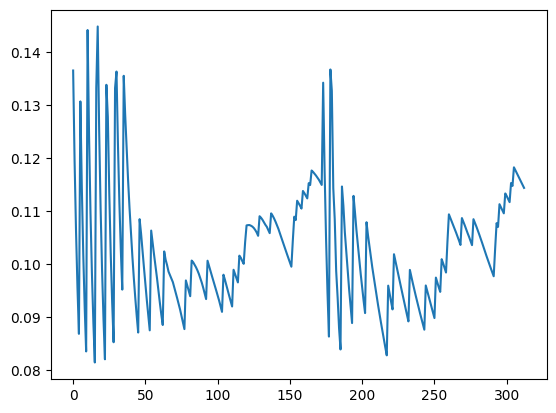

In [41]:
model_losses = models['test_model_1']['model'].losses
Q1 = np.percentile(model_losses, 25)
Q3 = np.percentile(model_losses, 75)
IQR = Q3 - Q1

# Define a lower and upper bound
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on the bounds
outliers_removed = [x for x in model_losses if lower_bound <= x <= upper_bound]

plt.plot(range(len(outliers_removed)), outliers_removed)

In [59]:
trained_datasets = {}

In [105]:
def main():
    for i in range(1, 78):
        model_name = 'model' + str(i)
        nv_model = 'nv_model' + str(i)
        v_model = 'v_model' + str(i)
        train = 'train_df' + str(i)
        test = 'test_df' + str(i)

        output = {}
        nv_models = {}
        v_models = {}

        temp_train_df = create_aggregated_columns(tables[train], ['non-violent', 'violent', 'bike_rides'])
        temp_test_df = create_aggregated_columns(tables[test], ['non-violent', 'violent', 'bike_rides'])

        temp_train_df = normalize_dataframe(temp_train_df)
        temp_test_df = normalize_dataframe(temp_test_df)


        print(f"Training non-violent model for {model_name}")
        globals()[nv_model] = LinearRegression(temp_train_df, ['non-violent_6h_agg', 'non-violent_12h_agg', 'non-violent_24h_agg', 'violent_6h_agg', 'violent_12h_agg',
                                                    'violent_24h_agg', 'bike_rides_6h_agg', 'bike_rides_12h_agg', 'bike_rides_24h_agg'], 'non-violent', 
                                                    initial_learning_rate=0.0001, learning_rate_decay=.999, epochs=10000)
        

        globals()[nv_model].set_train_dataset(temp_train_df)
        globals()[nv_model].set_test_dataset(temp_test_df)

        nv_output = globals()[nv_model].list_to_models(temp_train_df, nv_models, patience=100)
        output['nv-model'] = globals()[nv_model]
        output['non-violent'] = nv_models

        trained_datasets[model_name] = output

        print(f"Training violent model for {model_name}")
        globals()[v_model] = LinearRegression(temp_train_df, ['non-violent_6h_agg', 'non-violent_12h_agg', 'non-violent_24h_agg', 'violent_6h_agg', 'violent_12h_agg',
                                                    'violent_24h_agg', 'bike_rides_6h_agg', 'bike_rides_12h_agg', 'bike_rides_24h_agg'], 'violent', 
                                                    initial_learning_rate=0.0001, learning_rate_decay=.999, epochs=10000)
        
        globals()[v_model].set_train_dataset(temp_train_df)
        globals()[v_model].set_test_dataset(temp_test_df)

        v_output = globals()[v_model].list_to_models(temp_train_df, v_models, patience=100)
        output['v-model'] = globals()[v_model]
        output['violent'] = v_models

        trained_datasets[model_name] = output

In [110]:
main()

Training non-violent model for model1
2023-10-30 05:08:29 - Epoch 50 - Total Error for the Model: 0.3894838676777907 | Relative Error for the Model: 40.320840999937765
[0.012598965833425747] 8.652197422593195e-17
2023-10-30 05:09:29 - Epoch 100 - Total Error for the Model: 0.43019600339100156 | Relative Error for the Model: 40.40106756688232
[0.01642408962237892] 8.784994043593648e-17
Training stopped due to lack of improvement for 100 epochs. Current Error - 0.42133983825519955
Training Complete. Final Error: 0.3806565646868329
Trained temp_model_1 with 1 feature columns.
Model: y = (0.01027389550757478 * non-violent_6h_agg) + 8.789107173928806e-17
2023-10-30 05:11:24 - Epoch 50 - Total Error for the Model: 0.3827591979481695 | Relative Error for the Model: 20.433843422621916
[0.012549029143840165, 0.008537235241103948] 8.857881814105311e-17
2023-10-30 05:12:53 - Epoch 100 - Total Error for the Model: 0.42281978721508534 | Relative Error for the Model: 19.9216604056177
[0.016309789412

IndexError: list index out of range